In [1]:
import os
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split

# Reading Data using Pandas and SQLite3

In [2]:
# helper function to join tables across different database (.db) files
def join_tables(tables):
    
    df = tables[0]
    for table in tables[1:]:
        df = pd.concat([df, table])
        
    return df.reset_index(drop=True)

# joining all database (.db) files of folder
def get_all_databases(folder):
    
    string_tables = []
    ull_tables = []
    files = os.listdir(folder)
    
    # iterating through all files of folder to append tables
    for file in files:
        path = os.path.join(folder, file)
        con = sqlite3.connect(path)
        string_tables.append(pd.read_sql_query('SELECT COUNTERS_STRING_TIME_DATA.*, INPUTS.INPUT_DESCRIPTION FROM COUNTERS_STRING_TIME_DATA LEFT JOIN INPUTS WHERE COUNTERS_STRING_TIME_DATA.ID_INPUT == INPUTS.ID_INPUT', con))
        ull_tables.append(pd.read_sql_query('SELECT COUNTERS_ULL_TIME_DATA.*, INPUTS.INPUT_DESCRIPTION FROM COUNTERS_ULL_TIME_DATA LEFT JOIN INPUTS WHERE COUNTERS_ULL_TIME_DATA.ID_INPUT == INPUTS.ID_INPUT', con))
        
    # concatenating tables into single DataFrames
    string_df = join_tables(string_tables)
    string_df.loc[:, 'VALUE'] = string_df.loc[:, 'VALUE'].replace({'WWAHost.exe': 'Netflix.exe'}) 
    string_df.loc[:, 'VALUE'] = string_df.loc[:, 'VALUE'].str.lower()
    string_df.loc[string_df['INPUT_DESCRIPTION'] == 'Mouse cursor icon state.', 'ID_INPUT'] = 2
    string_df.loc[string_df['INPUT_DESCRIPTION'] == 'Foreground window .exe process.', 'ID_INPUT'] = 3
    ull_df = join_tables(ull_tables)
    ull_df.loc[ull_df['INPUT_DESCRIPTION'] == 'Mouse X position in pixel(s)', 'ID_INPUT'] = 0
    ull_df.loc[ull_df['INPUT_DESCRIPTION'] == 'Mouse Y position in pixel(s)', 'ID_INPUT'] = 1
    ull_df.loc[ull_df['INPUT_DESCRIPTION'] == 'Foreground window is immersive.', 'ID_INPUT'] = 4
    ull_df.loc[ull_df['INPUT_DESCRIPTION'] == 'Foreground window is hung.', 'ID_INPUT'] = 5
    return (string_df.drop('INPUT_DESCRIPTION', axis=1), ull_df.drop('INPUT_DESCRIPTION', axis=1))

In [3]:
# LAPTOP-MP2GILK8
string_df_0, ull_df_0 = get_all_databases('group3_collected_data')

# DESKTOP-E83M0TM
string_df_1, ull_df_1 = get_all_databases('group3_collected_data_pc_1')

In [4]:
display(string_df_0.head())
display(ull_df_0.head())

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA
0,2021-11-20 21:30:29.491,2,idc_arrow,0
1,2021-11-20 21:30:30.578,3,cmd.exe,0
2,2021-11-20 21:30:31.512,2,idc_sizewe,0
3,2021-11-20 21:30:31.847,2,idc_arrow,0
4,2021-11-20 21:30:34.994,2,idc_hand,0


,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA
0,2021-11-20 21:30:29.436,0,791,0
1,2021-11-20 21:30:29.436,1,108,0
2,2021-11-20 21:30:30.442,0,814,0
3,2021-11-20 21:30:30.442,1,70,0
4,2021-11-20 21:30:30.578,4,2072,0


# Exploratory Data Analysis

In [23]:
# getting value counts of foreground applications on LAPTOP-MP2GILK8
foreground_0 = string_df_0[string_df_0['ID_INPUT'] == 3]['VALUE'].value_counts()
# foreground_0

In [24]:
# getting value counts of foreground applications on DESKTOP-E83M0TM
foreground_1 = string_df_1[string_df_1['ID_INPUT'] == 3]['VALUE'].value_counts()
# foreground_1

C:\Users\jared\AppData\Local\Temp/ipykernel_8048/1308971070.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels=foreground_0.index[:10], rotation=90);
C:\Users\jared\AppData\Local\Temp/ipykernel_8048/1308971070.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels=foreground_1.index[:10], rotation=90);


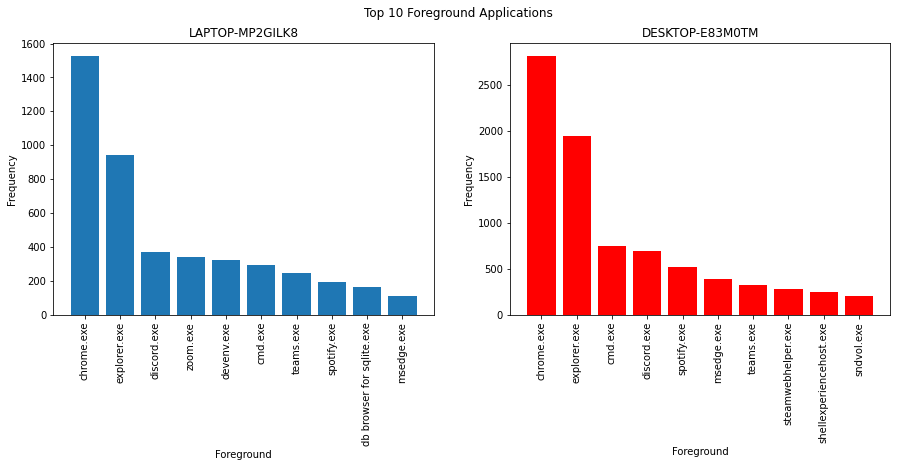

In [33]:
# plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Top 10 Foreground Applications')

ax1.bar(x=foreground_0.index[:10], height=foreground_0.values[:10])
ax1.set_xticklabels(labels=foreground_0.index[:10], rotation=90);
# ax1.tick_params(rotation=90);
ax1.set(xlabel='Foreground', ylabel='Frequency')
ax1.set_title('LAPTOP-MP2GILK8');

ax2.bar(x=foreground_1.index[:10], height=foreground_1.values[:10], color='red')
ax2.set_xticklabels(labels=foreground_1.index[:10], rotation=90);
# ax2.tick_params(rotation=90);
ax2.set(xlabel='Foreground', ylabel='Frequency')
ax2.set_title('DESKTOP-E83M0TM');

In [8]:
# getting value counts of mouse icons on LAPTOP-MP2GILK8
icon_0 = string_df_0[string_df_0['ID_INPUT'] == 2]['VALUE'].value_counts()

# getting value counts of mouse icons on DESKTOP-E83M0TM
icon_1 = string_df_1[string_df_1['ID_INPUT'] == 2]['VALUE'].value_counts()

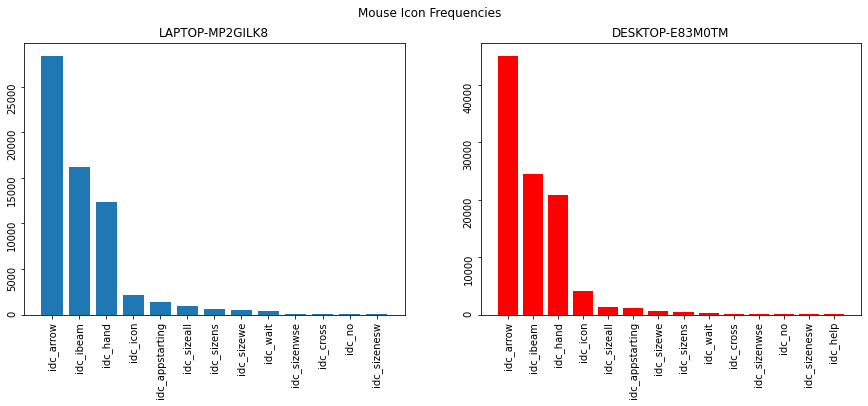

In [9]:
# plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Mouse Icon Frequencies')

ax1.bar(x=icon_0.index, height=icon_0.values)
ax1.tick_params(rotation=90);
ax1.set_title('LAPTOP-MP2GILK8');

ax2.bar(x=icon_1.index, height=icon_1.values, color='red')
ax2.tick_params(rotation=90);
ax2.set_title('DESKTOP-E83M0TM');

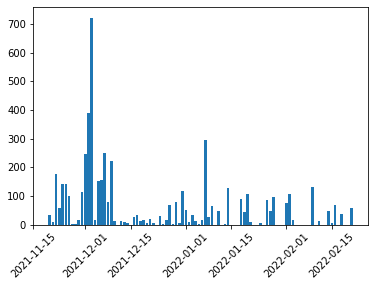

In [10]:
string_df_0['MEASUREMENT_TIME'] = string_df_0['MEASUREMENT_TIME'].apply(lambda x: pd.to_datetime(x).date())
foreground_0 = string_df_0[string_df_0['ID_INPUT'] == 3].groupby('MEASUREMENT_TIME').agg('count')['VALUE']
plt.bar(x=foreground_0.index, height=foreground_0.values)
plt.xticks(rotation=45);

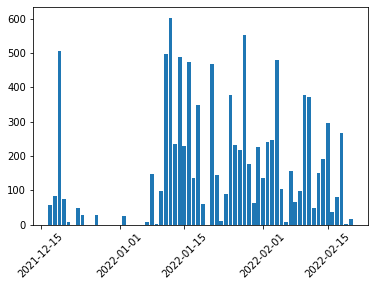

In [11]:
string_df_1['MEASUREMENT_TIME'] = string_df_1['MEASUREMENT_TIME'].apply(lambda x: pd.to_datetime(x).date())
foreground_1 = string_df_1[string_df_1['ID_INPUT'] == 3].groupby('MEASUREMENT_TIME').agg('count')['VALUE']
plt.bar(x=foreground_1.index, height=foreground_1.values)
plt.xticks(rotation=45);

# Problem 1
Predict the likelihood of using an application given the previous sequence of application usage.

In [40]:
from collections import defaultdict

def get_totals(df):
    
    sequence = df[df['ID_INPUT'] == 3]['VALUE'].values
    pairs = defaultdict(int)

    for i in range(len(sequence)-1):
        pairs[(sequence[i], sequence[i+1])] += 1

    return pairs

def get_cond_probs(df):
    
    cond_probs = defaultdict(list)
    foregrounds = df[df['ID_INPUT'] == 3]['VALUE'].value_counts()
    pairs = sorted(get_totals(df).items(), key=lambda x: (x[0][0], -x[1]))
    # pairs = get_app_totals(df)

    for (pair, freq) in pairs:
        cond_probs[pair[0]].append((pair[1], round(freq/foregrounds[pair[0]], 3)))

    return cond_probs

def get_cond_prob_plots(df):

    cond_probs = get_cond_probs(df)
    for app in cond_probs:
        series = pd.DataFrame(cond_probs[app])
        plt.figure(figsize=(8, 6))
        plt.bar(x=series[0], height=series[1])
        plt.title(app);
        plt.xlabel('Future Foreground');
        plt.ylabel('Probability');
        plt.xticks(rotation=90)
        plt.grid(True, alpha=0.5)
        plt.show()

In [41]:
# LAPTOP-MP2GILK8
# get_cond_probs(string_df_0)

# # DESKTOP-E83M0TM
# get_cond_probs(string_df_1)

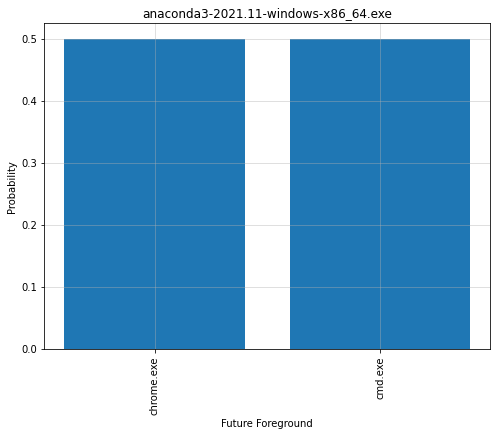

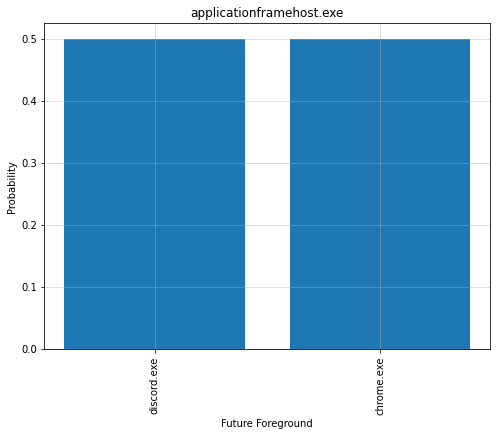

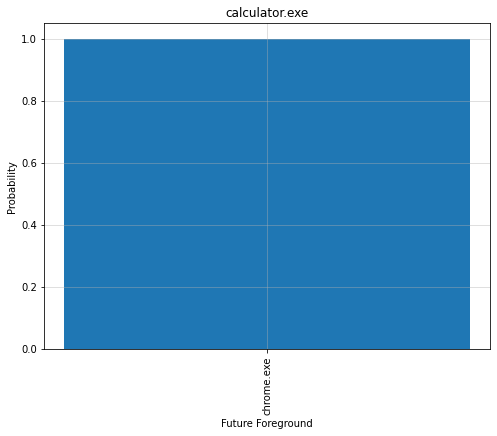

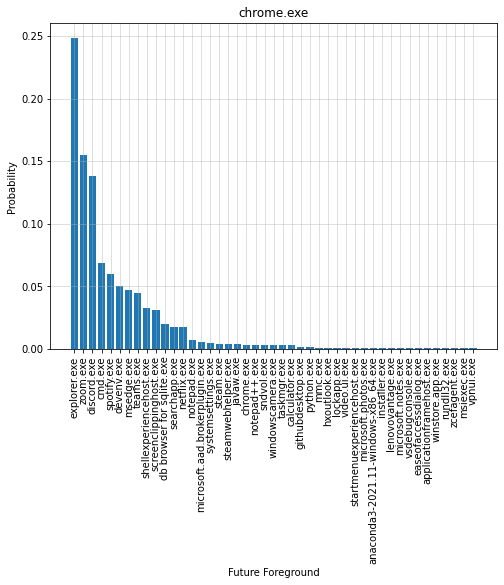

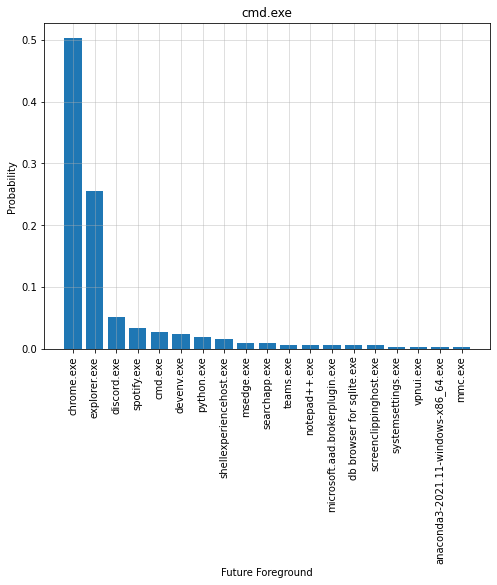

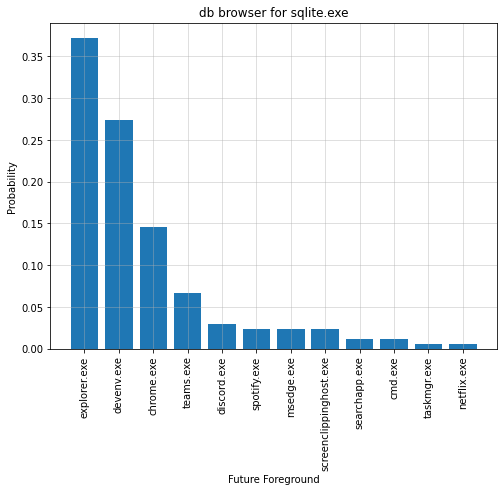

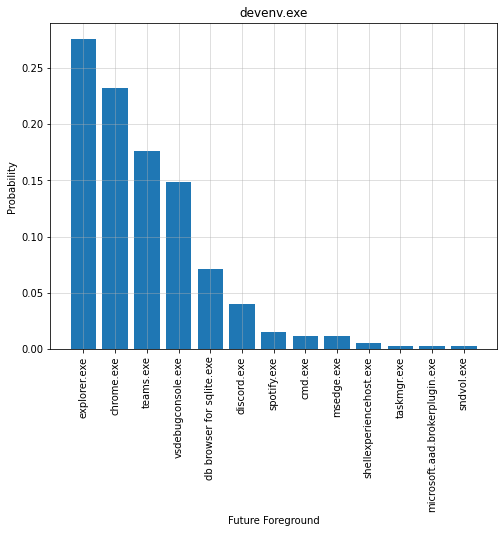

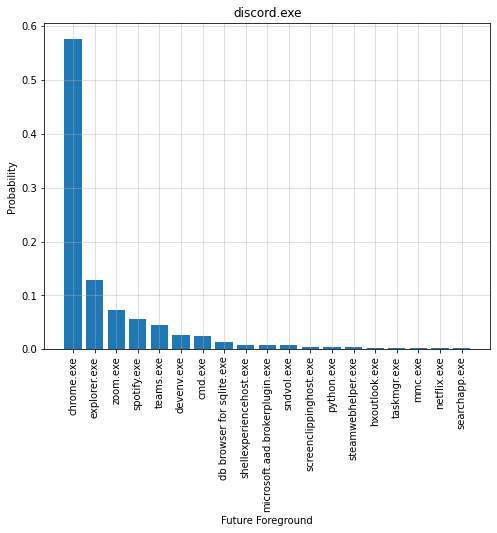

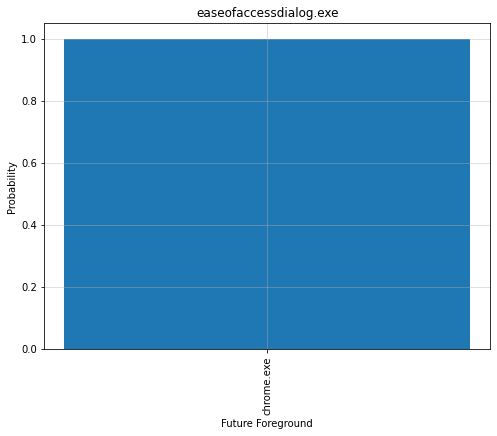

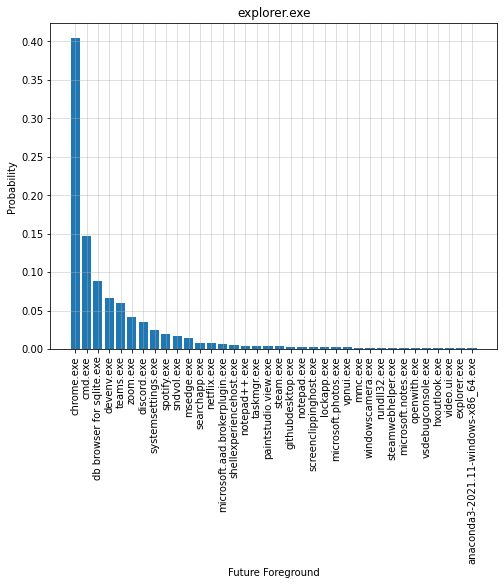

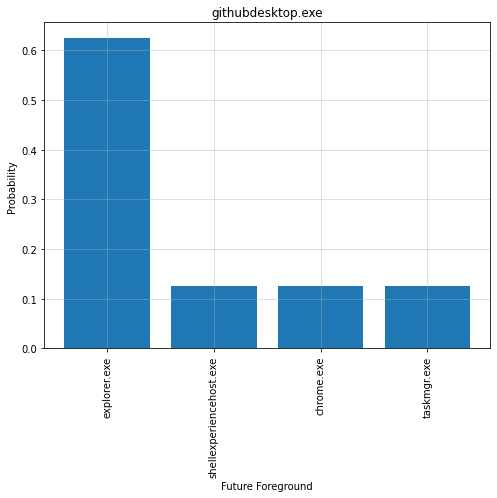

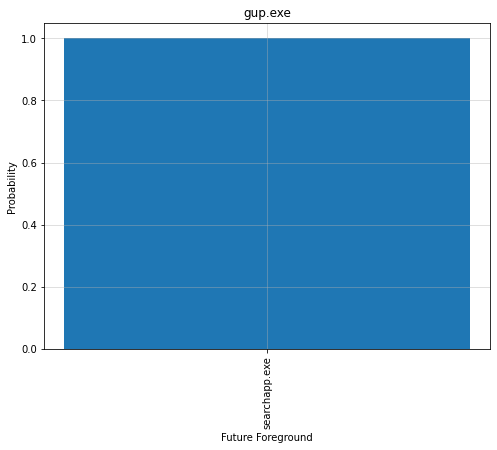

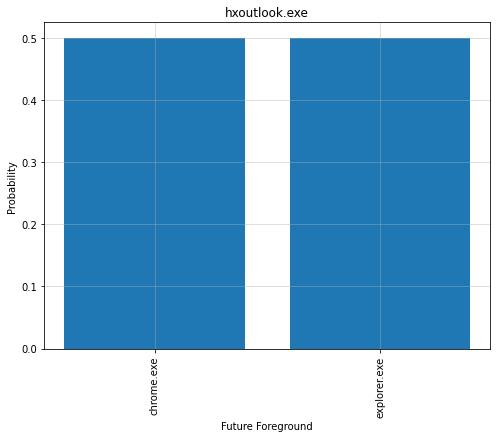

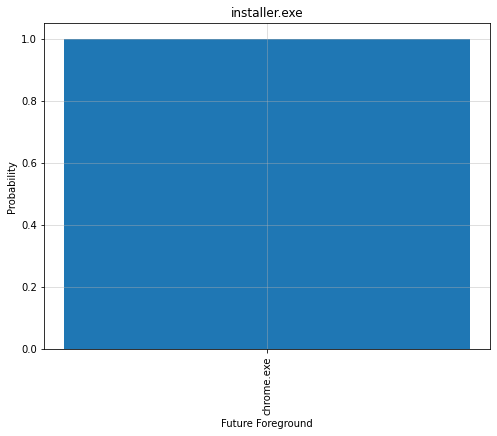

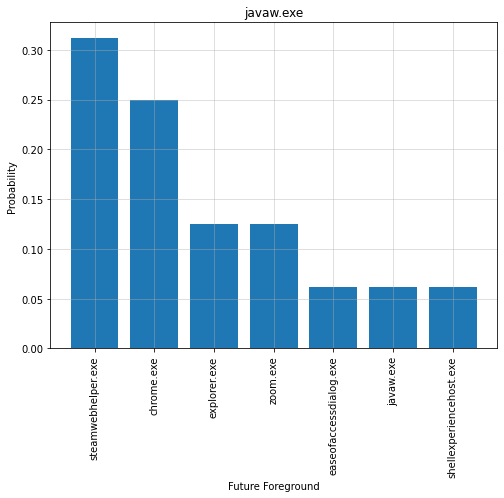

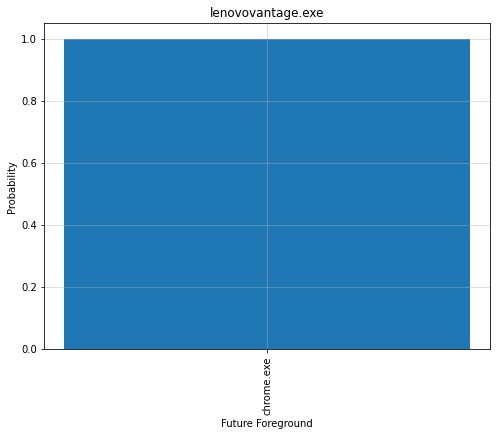

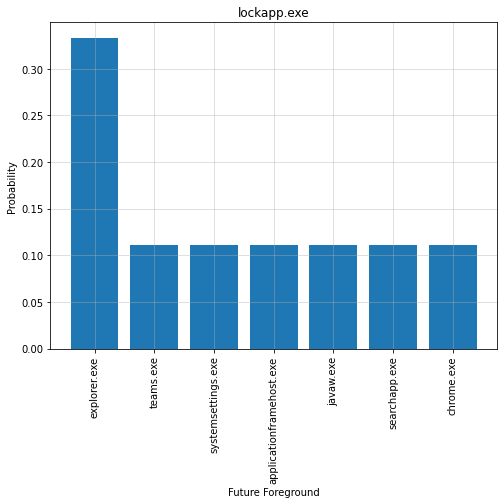

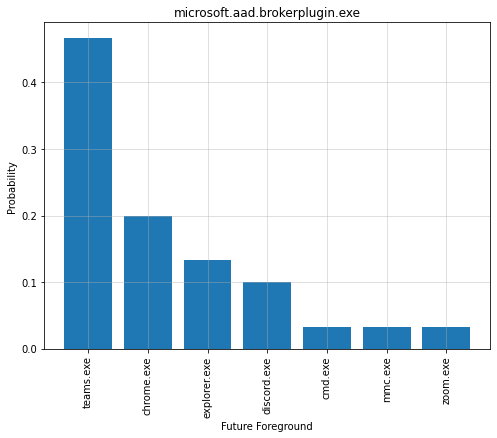

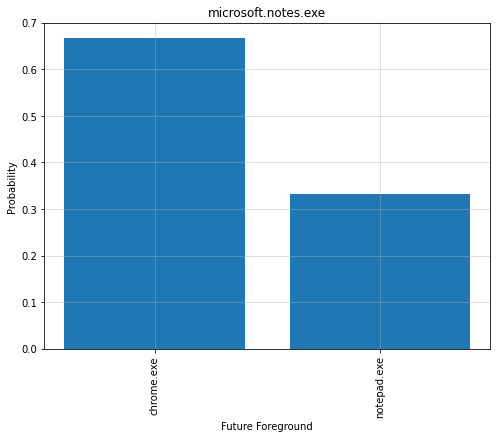

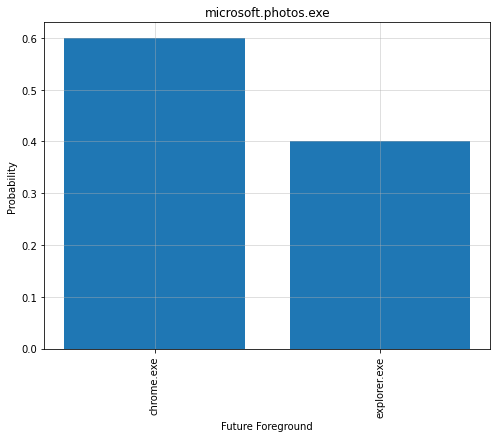

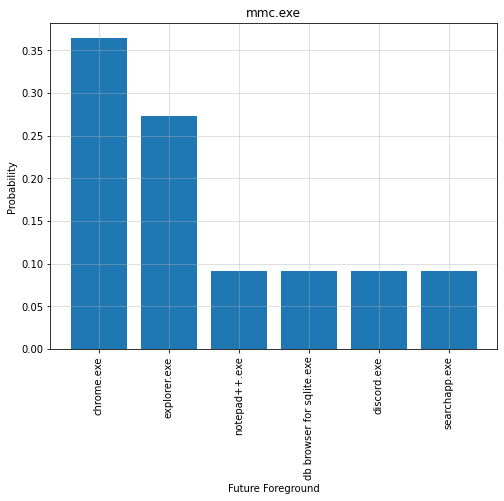

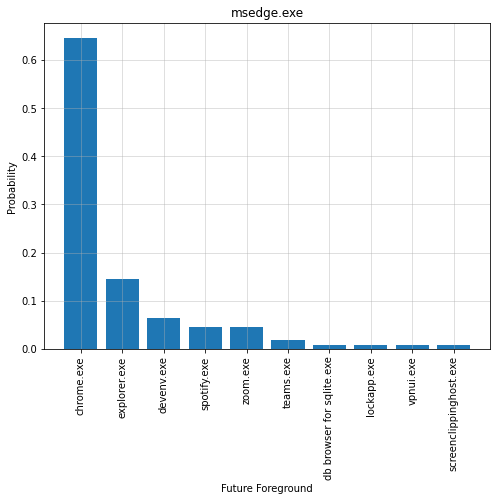

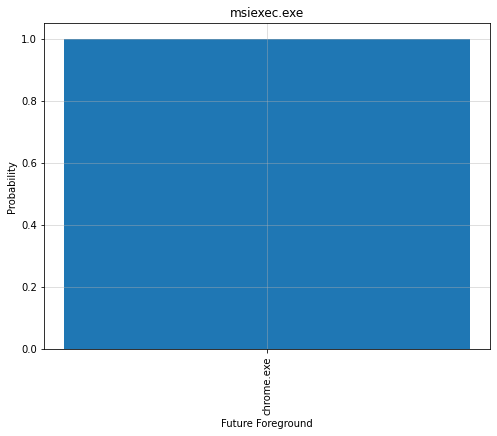

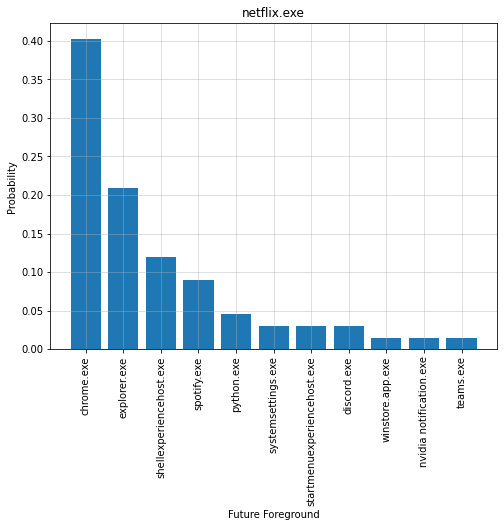

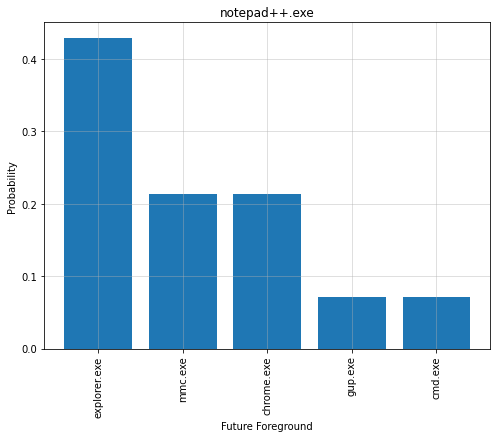

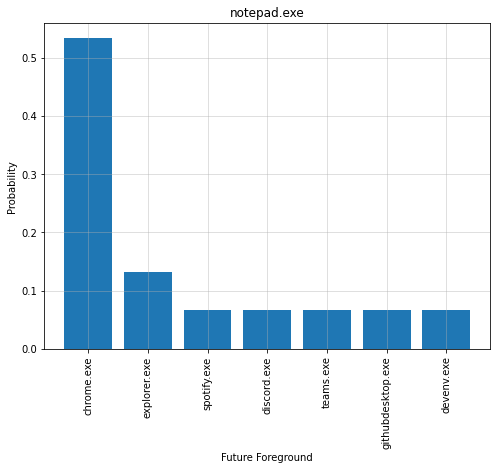

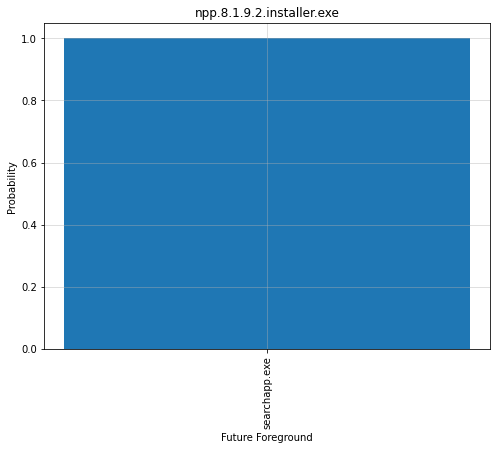

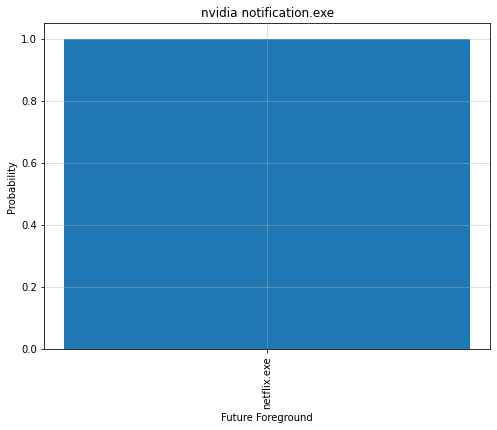

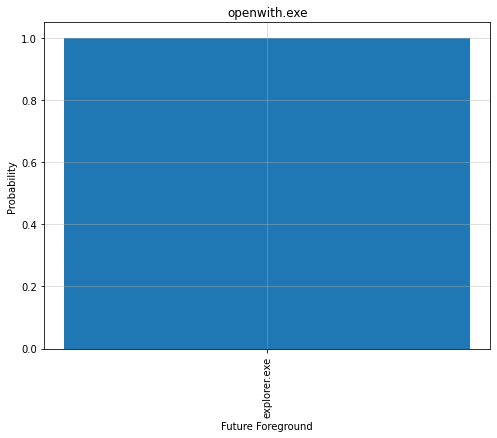

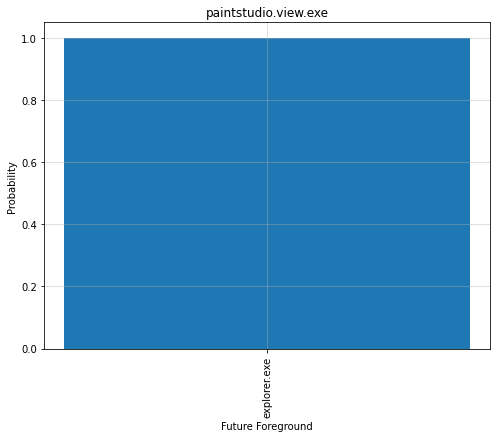

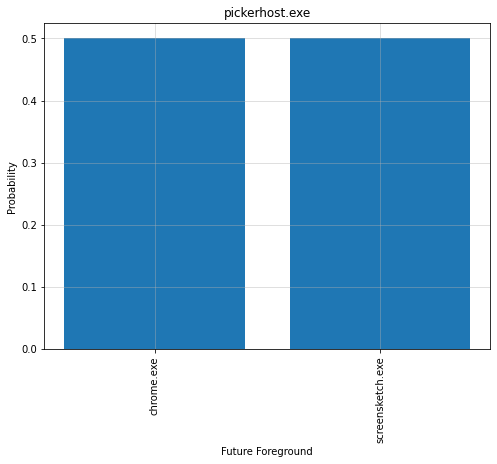

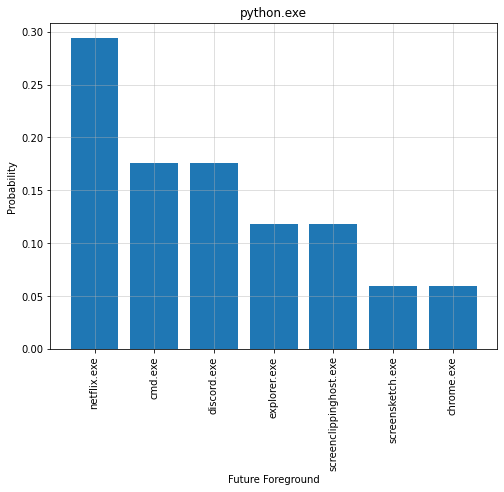

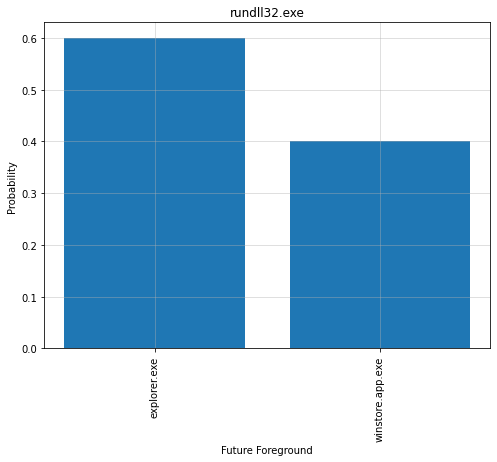

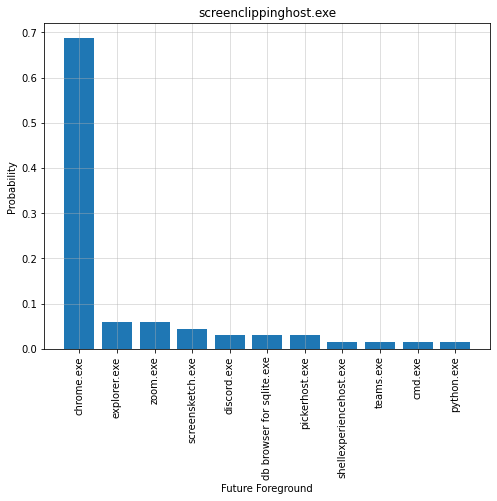

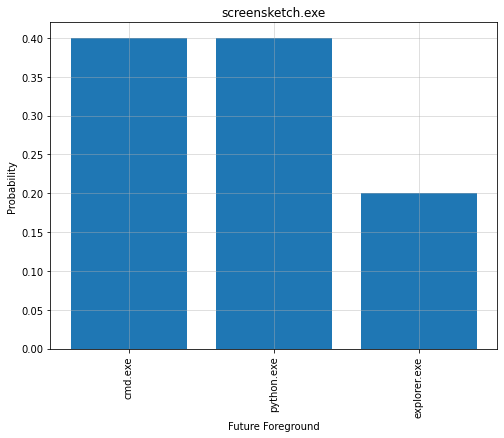

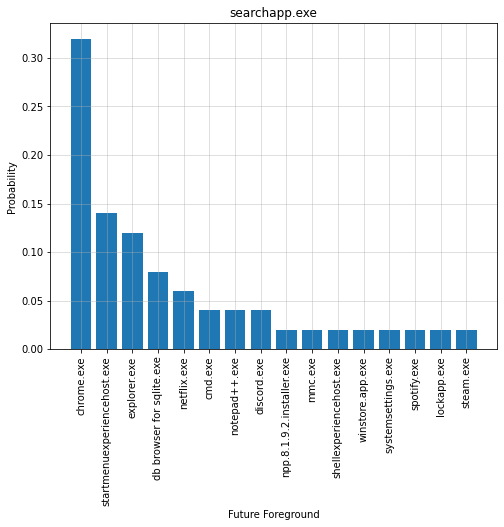

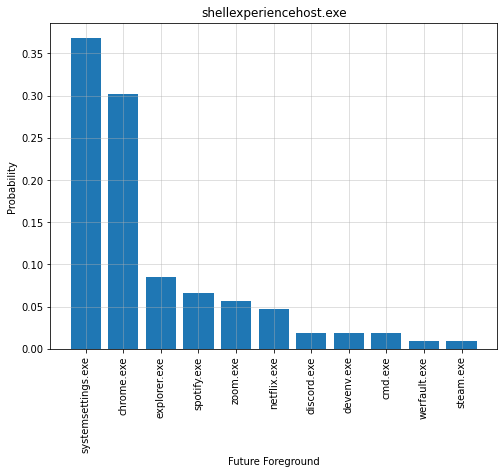

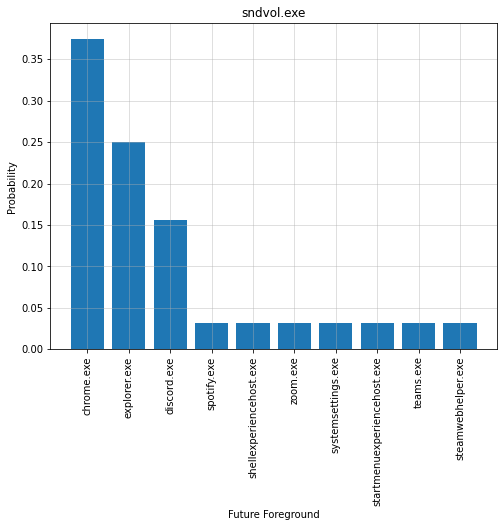

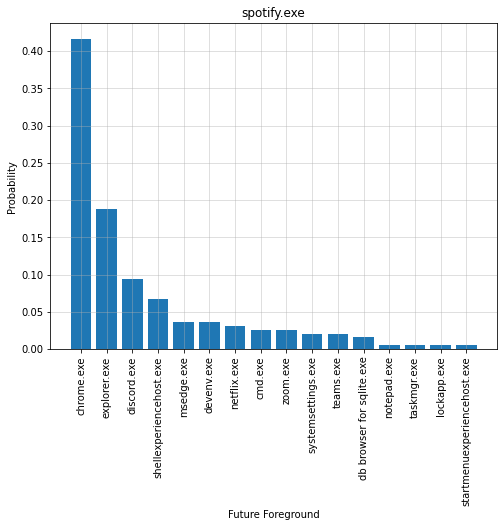

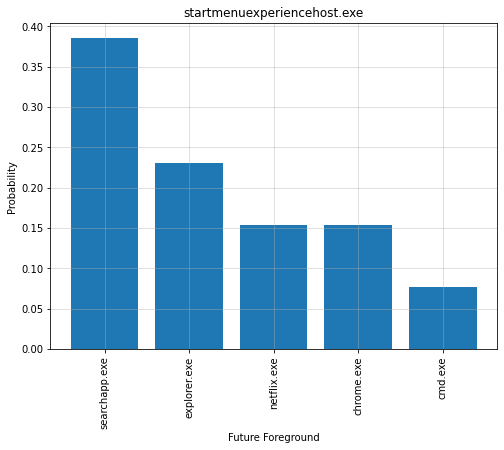

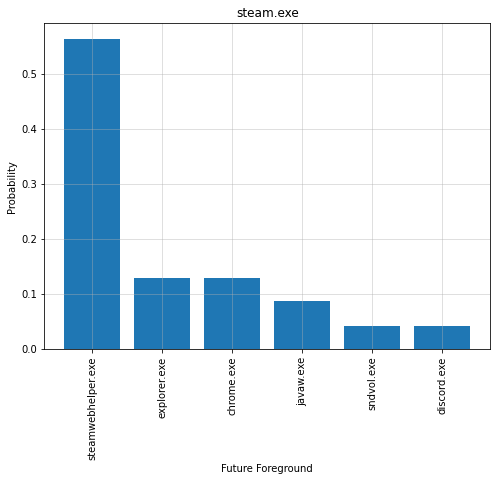

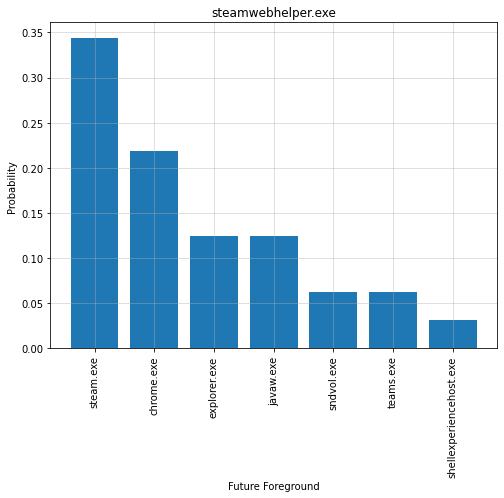

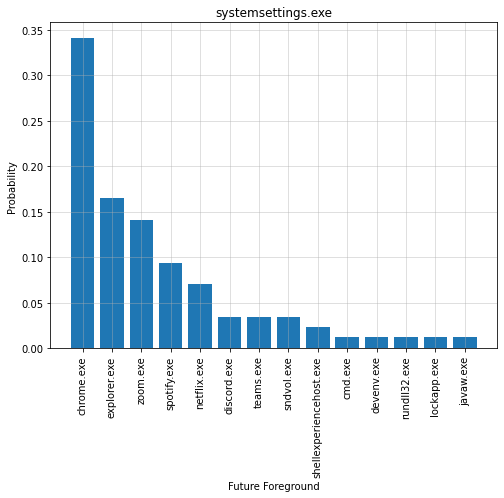

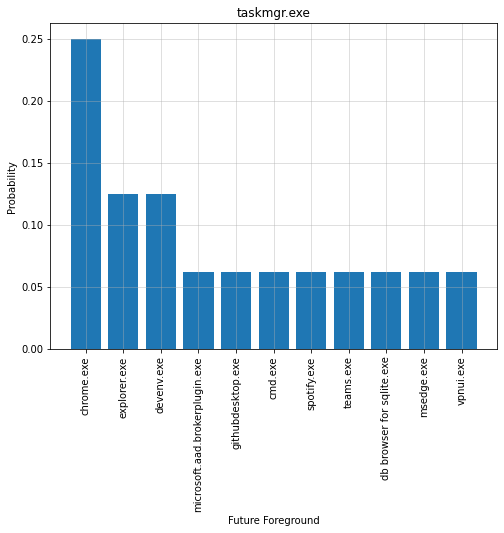

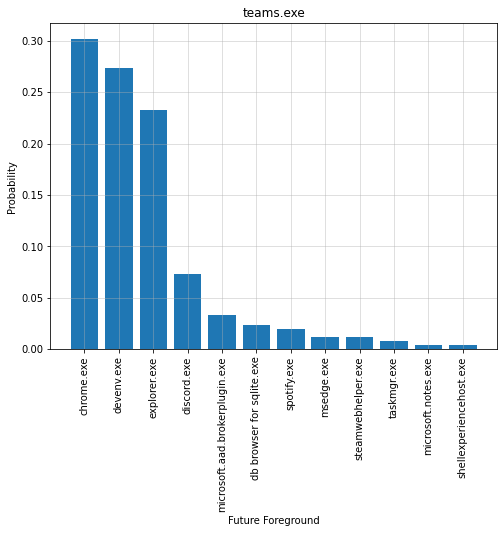

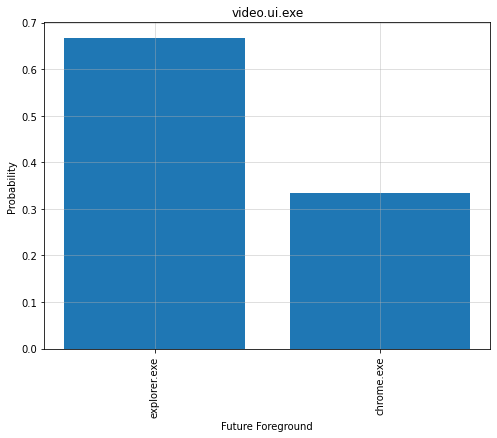

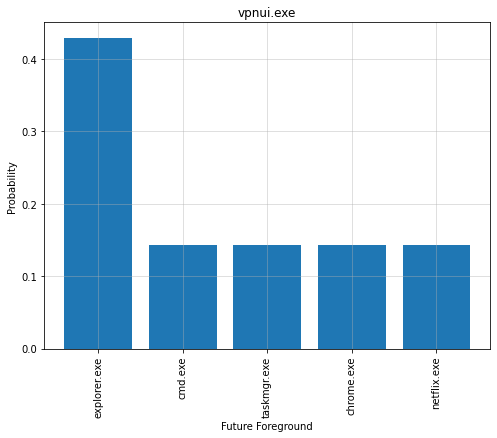

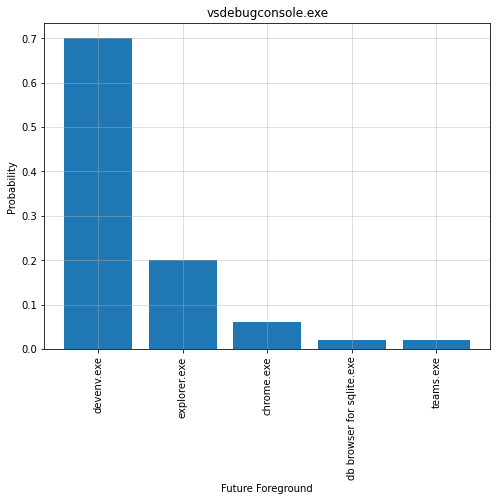

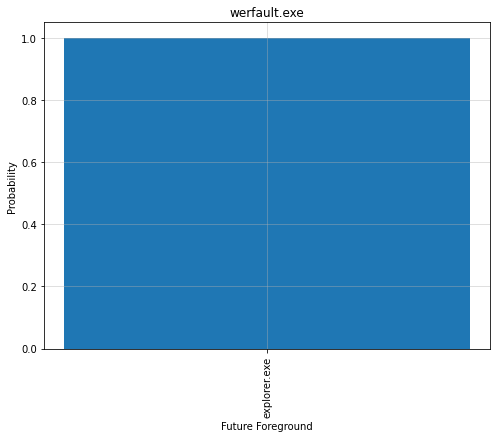

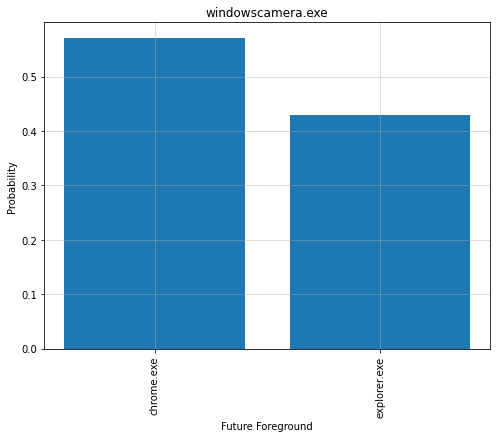

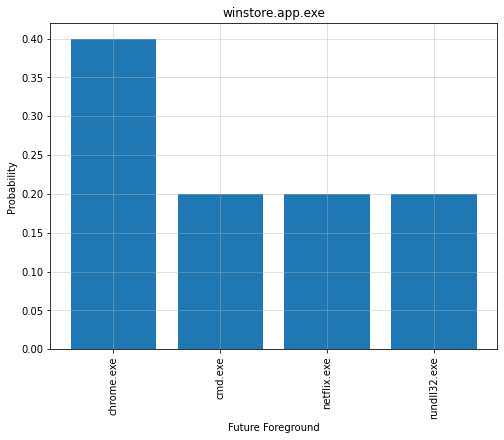

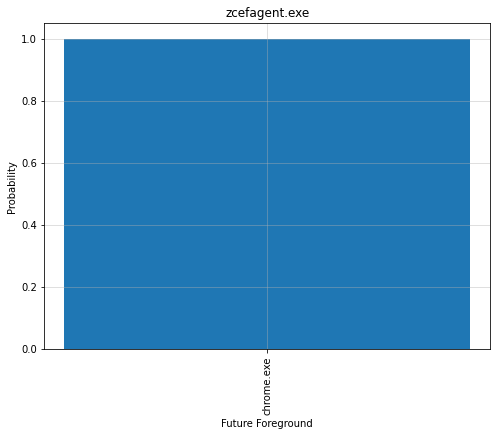

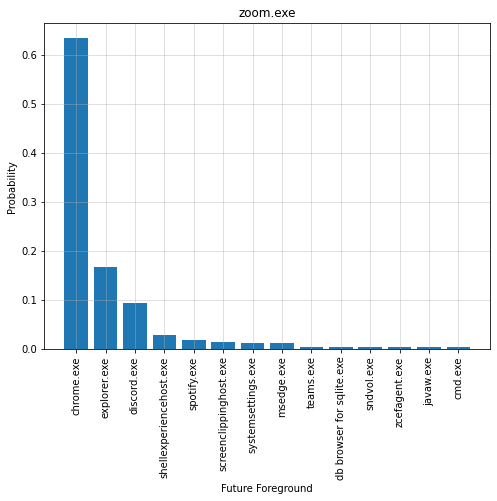

In [42]:
# # LAPTOP-MP2GILK8
get_cond_prob_plots(string_df_0)

# DESKTOP-E83M0TM
# get_cond_prob_plots(string_df_1)

In [15]:
def clean(df, condition_1=True):
    
    sequence = df[df['ID_INPUT'] == 3]['VALUE'].values
    pairs = []
    
    for i in range(len(sequence)-1):
        if condition_1 == True:
            if sequence[i] == sequence[i+1]:
                continue
            else:
                pairs.append([sequence[i], sequence[i+1]])
        else:
            pairs.append([sequence[i], sequence[i+1]])
        
    return pd.DataFrame(pairs, columns=['X', 'y'])

class first_order_HMM(object):
    
    def __init__(self, computer=0):
        if computer == 0:
            self.uniques = sorted(string_df_0[string_df_0['ID_INPUT'] == 3]['VALUE'].unique())
        else:
            self.uniques = sorted(string_df_1[string_df_1['ID_INPUT'] == 3]['VALUE'].unique())
        self.data = pd.DataFrame()
        self.counts = defaultdict(float)
        self.priors = defaultdict(float)
        self.posteriors = defaultdict(float)

    def fit(self, X, y):
        """
        inputs :
            X : a list of prior foreground applications
            y : a list of subsequent foreground applications from the prior foreground applications
            
        outputs:
            None
        """
        
        self.data = pd.DataFrame({'X': X, 'y': y})
        
        def get_counts():
            counts = defaultdict(float)
            for foreground in self.data.values:
                counts[foreground[0]] += 1
            counts[self.data.values[-1][1]] += 1
            return pd.Series(dict(sorted(counts.items())))
        
        def get_priors():
            priors = defaultdict(float)
            # getting percentage of each unique foreground's occurrence
            for foreground, count in self.counts.items():
                priors[foreground] = count / (len(self.data.values) + 1)
            return pd.Series(priors)

        def get_posteriors():
            # creating empty conditional probability matrix
            posteriors = pd.DataFrame(
                np.zeros([len(self.uniques), len(self.uniques)]), 
                index=self.uniques, 
                columns=self.uniques
            )           
            # counting pairs of foregrounds
            for pair in self.data.values:
                posteriors.loc[pair[0], pair[1]] += 1
            # calculating conditional probability of foreground A given foreground B
            posteriors = posteriors.apply(lambda x: x / sum(x), axis=1)
            return posteriors
        
        self.counts = get_counts()
        self.priors = get_priors()
        self.posteriors = get_posteriors()
    
    def predict(self, X, n_foregrounds=1):
        """
        inputs :
            X : a list of prior foreground applications
            n_foregrounds : number of predicted foregrounds to return (default: 1)
            
        outputs :
            y : a list of predicted subsequent foreground applications 
        """
        
        # outputting foreground application with maximum conditional probability
        y = []
        for x in X:
            # outputting foreground application with maximum conditional probability
            # y = np.append(y, self.posteriors.loc[x,:].idxmax())
            y.append(list(self.posteriors.loc[x,:].sort_values(ascending=False)[:n_foregrounds].index))
            
        return y
            
    def accuracy(self, y_test, y_pred):
        """
        inputs :
            y_test : a list of true subsequent foreground applications
            y_pred : a list of predicted subsequent foreground applications
            
        outputs :
            accuracy : accuracy of trained model on y_test
        """
        correct = 0
        for i, y in enumerate(y_test):
            if y in y_pred[i]:
                correct += 1
        accuracy = correct / len(y_test)
        
        return accuracy

In [16]:
model = first_order_HMM()
df = clean(string_df_0)
X_train, X_test, y_train, y_test = train_test_split(df['X'], df['y'], test_size=0.2, random_state=99)

model.fit(X_train, y_train)
y_pred = model.predict(X_test, n_foregrounds=3)
accuracy = model.accuracy(y_test, y_pred)
print('Test accuracy: ', accuracy)

Test accuracy:  0.676555023923445


In [17]:
model = first_order_HMM(computer=1)
df = clean(string_df_1)
X_train, X_test, y_train, y_test = train_test_split(df['X'], df['y'], test_size=0.2, random_state=99)

model.fit(X_train, y_train)
y_pred = model.predict(X_test, n_foregrounds=3)
accuracy = model.accuracy(y_test, y_pred)
print('Test accuracy: ', accuracy)

Test accuracy:  0.6434223541048467


In [18]:
X_test.head()

850         csgo.exe
6517       steam.exe
3548    explorer.exe
3180      chrome.exe
6377         cmd.exe
Name: X, dtype: object

In [19]:
y_test.head()

850                 explorer.exe
6517                  sndvol.exe
3548    applicationframehost.exe
3180                 discord.exe
6377                  python.exe
Name: y, dtype: object

In [20]:
y_pred[:5]

[['sndvol.exe', 'explorer.exe', 'spotify.exe'],
 ['steamwebhelper.exe', 'explorer.exe', 'chrome.exe'],
 ['chrome.exe', 'cmd.exe', 'discord.exe'],
 ['explorer.exe', 'cmd.exe', 'discord.exe'],
 ['chrome.exe', 'explorer.exe', 'python.exe']]

In [21]:
model.posteriors

,_conda.exe,accountscontrolhost.exe,amdlink.exe,amdow.exe,among us.exe,anaconda3-2021.11-windows-x86_64.exe,applicationframehost.exe,bbtag.exe,blitz.exe,chrome.exe,...,taskmgr.exe,teams.exe,un_a.exe,valorant-win64-shipping.exe,video.ui.exe,vpnui.exe,winstore.app.exe,winword.exe,zcefagent.exe,zoom.exe
_conda.exe,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
accountscontrolhost.exe,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.666667,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
amdlink.exe,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
amdow.exe,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
among us.exe,0.0,0.0,0.0,0.0,0.0,0.0,0.015385,0.0,0.0,0.323077,...,0.0,0.000000,0.0,0.0,0.015385,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vpnui.exe,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
winstore.app.exe,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
winword.exe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zcefagent.exe,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
